# autotab

`autotab` is an attempt to create tablatures from a scan of a music score. The goal of this notebook is to give some kind of insight on entire processing pipeline of the project. 

## Problem statement
Given an adequate scan of a music score, detect all relevant glyphs for a tablature generation. 

Tablatures are a music representation for string instruments like guitars. Standard tablatures will not represent the duration of the notes. They will only encode the pitch of the notes with a number on a string. Here is a example of a tablature:

<img src="tablature_example.png" width="500">

Therefore, the glyphs that are relevant to this work are only the ones that affect the pitch (noteheads, accidentals, etc.). In other words, given an scan of a music score, detect all glyphs that affect the pitch of a note. The process of converting them to a tablature representation is trivial.

## Datasets
In machine learning, to train a classifier, there must be data. For this project, the two dataset of interest are the `deepscores` and `muscima` datasets. The former contains a gigantic amount of computer generated scores along with XML description files for the groundtruth data. The latter contains about 500 scores from different writers along with XML that describes the ground truth.

## Pipeline
Before utilizing the datasets, the first step is to formulate all the processing pipeline that would aim to detect every relevant glyph in a score. The reason behind this is that the training processes have to behave as similarly as inference.

Music scores are a kind of natural language. Like in any natural language, there is a hierchichal pattern of representation. In a music score, there are staff lines. In a staff line there are measures. Finally, in measure, there are glyphs. For the purpose of the project, measures are not a concern since they do not affect pitch.

That being said, the first step in the pipeline would be:

**1. Detect all the staff lines in a given score**

Fortunately, this was already done in another project called `staff-detect`. `staff-detect` can detect staffs in distorted images and rectify them the best way possible. For the purpose of this notebook, we will use a straight scan that was computer generated from the `deepscores` dataset. The staff lines will be removed because some ulterior steps in the pipeline will require it. Here is an example of staff line detection.

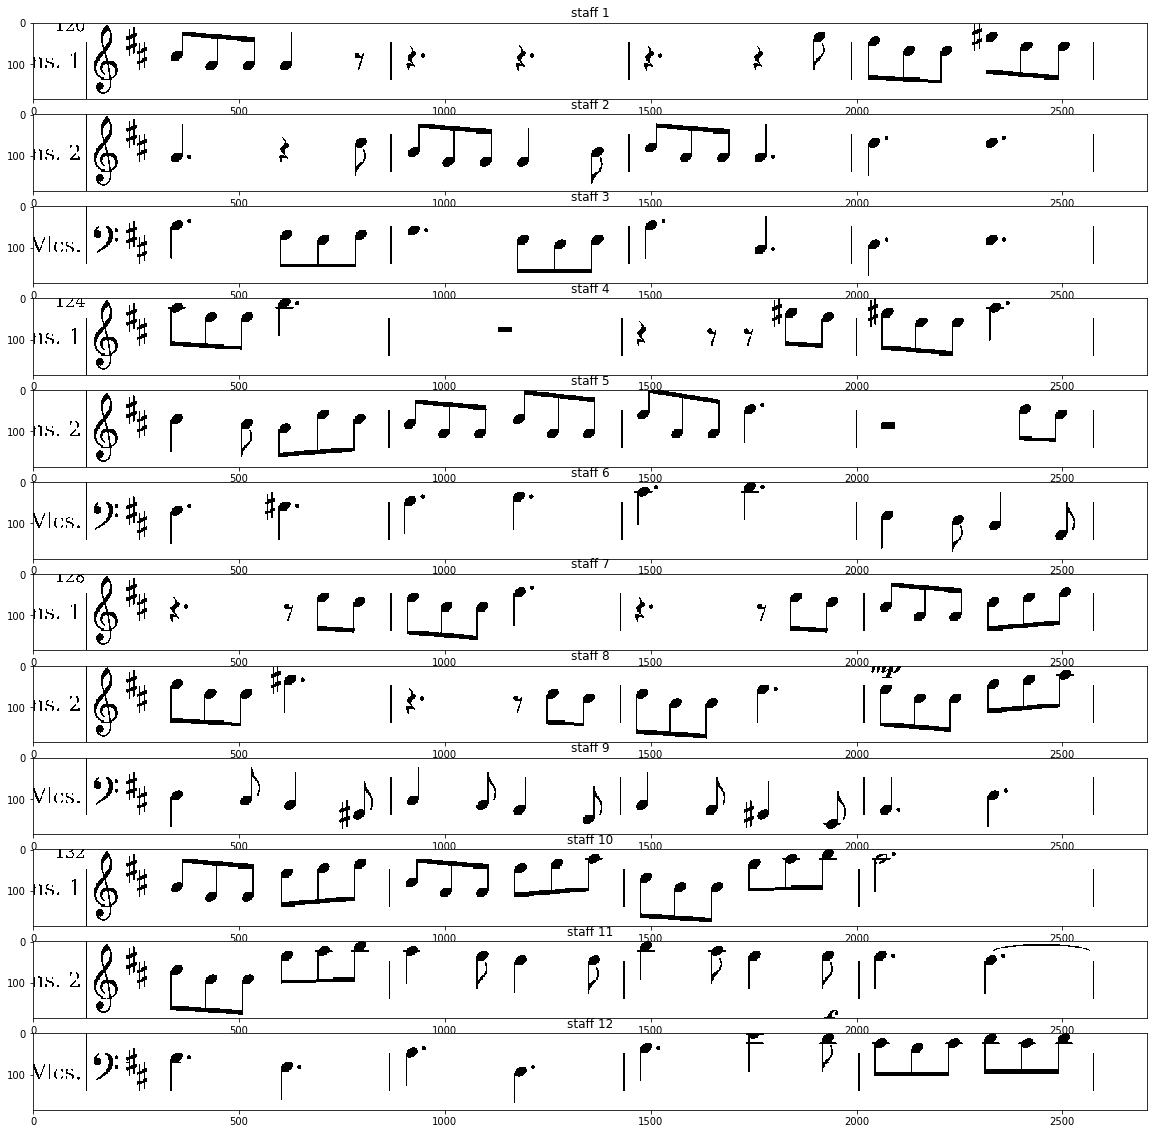

In [1]:
%matplotlib inline

from os.path import join, isfile, splitext, expanduser
from os import listdir
import sys
sys.path.append('../src/')

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from score import Glyph, BBox, Score

# Output of staff description and staff cleared images
STAV_OUTPUT_DIR = '../data/deepscores/'

# Choosing the first file in the directory for this notebook
test_file = [splitext(f)[0] for f in listdir(STAV_OUTPUT_DIR) if isfile(join(STAV_OUTPUT_DIR, f))][40]
# Reading the image
img = cv.imread(join(STAV_OUTPUT_DIR, test_file + '.png'), 0)
# Reading the staff description file
score = Score(join(STAV_OUTPUT_DIR, test_file + '.xml'))

fig, ax = plt.subplots(len(score), 1, figsize=(20,20))
for i, staff in enumerate(score):
    staff_image = score.extract_staff_image(img, staff)
    ax[i].imshow(staff_image, cmap='gray')
    ax[i].set_title('staff {}'.format(i + 1))

To convince ourselves that the staff detection module did not make mistakes, it is possible to draw all the staffs on the image.

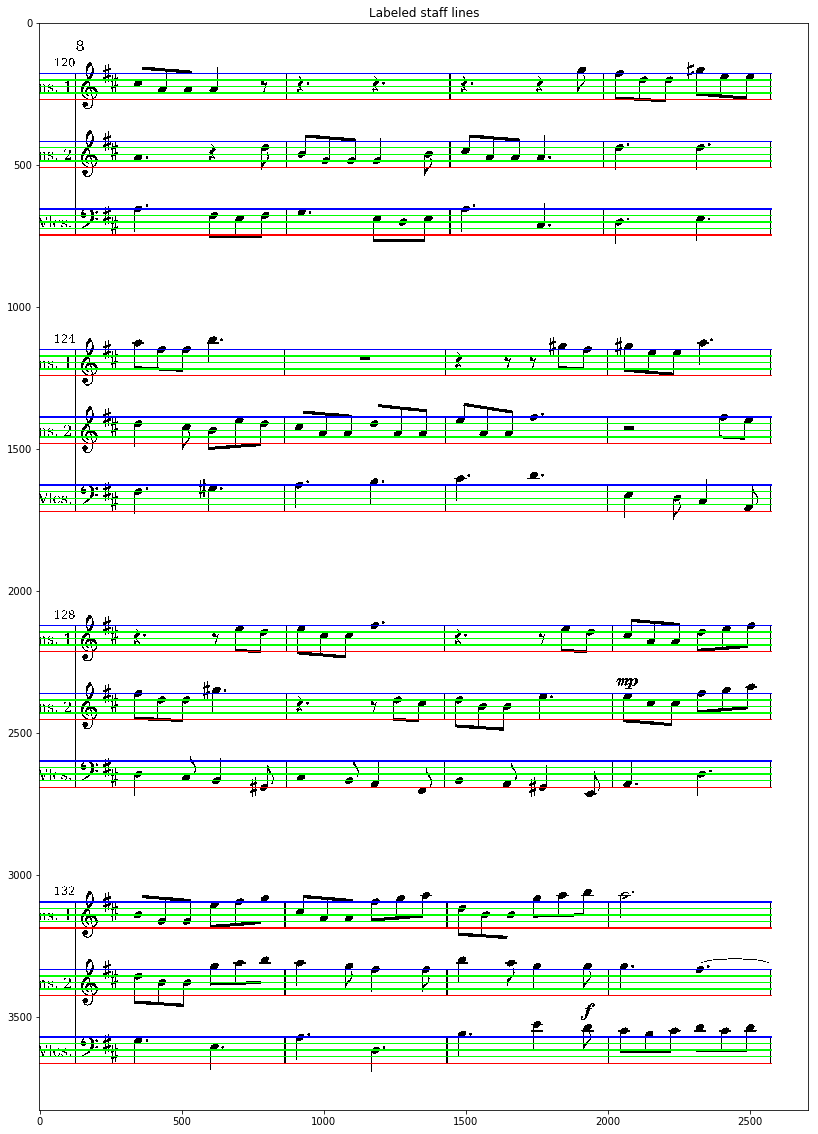

In [2]:
GREEN = 0,255,0
RED = 255,0,0
BLUE = 0,0,255

labeled_staff_img = img.copy()
# Converting the grayscale image into an rgb image
labeled_staff_img = np.stack((labeled_staff_img,) * 3, axis=-1)
plt.figure(figsize=(20,20))
for _, staff in enumerate(score):
    staff_pos = staff.start
    col = score.shape[1]
    cv.line(labeled_staff_img, (col, staff_pos), (col + score.staff_length, staff_pos), BLUE, 4)
    for j in range(1,5):
        row = staff_pos + j * (score.staff_height + score.staff_space)
        if j != 4:
            cv.line(labeled_staff_img, (col, row), (col + score.staff_length, row), GREEN, 4)
        else:
            cv.line(labeled_staff_img, (col, row), (col + score.staff_length, row), RED, 4)
            
plt.imshow(labeled_staff_img)
plt.title('Labeled staff lines');

Once a staff is detected, the process glyph detection will be independant from other staffs. This step will be done on both datasets. Even if the datasets themselves contain ground truth for staff lines too, it is deemed more adequate to use the process that would be used during inference. The high success rate (over 98%) of the `staff-detect` module means that even if a staff is wrongly positioned, it will not affect the training significantly enough.

The next process in the pipeline would be to 

**2. detect all the glyphs in the staff**.

This is no simple task. Other approaches aim to use modern deep learning methods like Mask RCNN to generalize the feature extraction by which a glyph is classified. Unfortunately, these methods have a terrible performance for OCR (or OMR in this case) and they require tremendous amounts of computational power. In the next section, the process by which a glyph is extracted will be explained.

## Glyph extraction
**A note on staffs**

Straight staffs can be described by three parameters:
1. $S$, staff space : Distance in pixels between each staff line.
2. $H$, staff height : Thickness in pixels of a line.
3. $e$, extra staff lines : The amount of staff lines above and under a staff that are not drawn.

Since each staff will have five staff lines and, once can expect a staff to be as thick as 

$S_t = S \cdot (4 + 2 \cdot e) + H \cdot (5 + 2 \cdot e)$

These parameters describe every staff in a score. They are common to every single staff. This is the only assumption made, that is that every staff in a score should behave like the others. Lines should be parallel and parameters should be equal. If those requirements are not meant, it is impossible to do any kind of staff line detection. This is where more computer vision methods will fail and it is judged reasonable to require it.

**End of note**

Let's first have a close look at a specific staff line. Let's pick the 12th (11th index) staff line from the example score. Music notation has strong patterns in its representation. First, of all, between each glyph, there is a spacing.  That spacing denotes the absence of a glyph. To illustre this, let's plot the number of black pixels in every column of the staff 12.

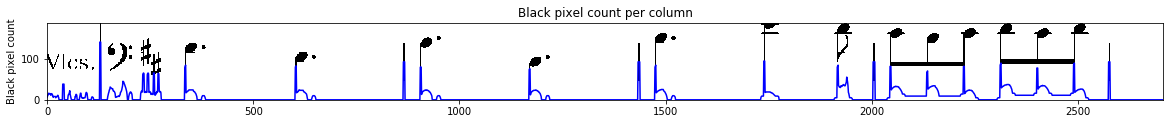

In [3]:
example_staff = score[11]
example_staff_image = score.extract_staff_image(img, example_staff)
col_count = np.count_nonzero(example_staff_image == 0, axis=0)

plt.figure(figsize=(20,20))
rows, cols = example_staff_image.shape
plt.imshow(example_staff_image, extent=[0, cols, 0, rows], cmap='gray')

plt.plot(col_count, 'b-')
plt.title('Black pixel count per column');
plt.ylabel('Black pixel count');

In the preceding plot, the columns where a glyph is present contain more black pixels than the empty ones. Before feeding every single region of interest in a staff to a neural network, one could filter all the regions that do not contain a glyph. A first horizontal sweep of the staff like previously done could hint at sections of the staff that may contain glyphs.

The threshold of glyph detection will be
$T = 7 \cdot H$

The rationale behind this value is that whenever a glyph is existent, it will vastly surpass the cumulative amount of staff height over one staff. Putting $T$ at $5 \cdot H$ would result in many false positives. Here is a plot of the threshold detection:

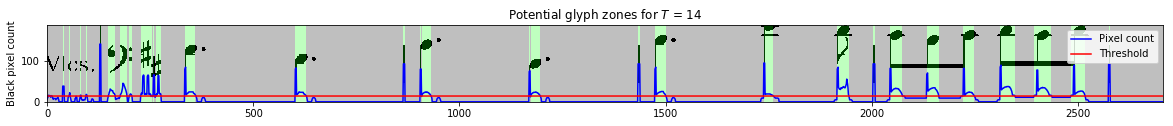

In [4]:
T = score.step_threshold
# Converting the grayscale image into an rgb image
rgb_staff_image = np.stack((example_staff_image,) * 3, axis=-1)
# Getting all zones where there might be a glyph
zone_bboxes = score.potential_regions(example_staff_image)

# Coloring the zones in green
mask_image = np.zeros(rgb_staff_image.shape)
for (xmin, xmax, ymin, ymax) in zone_bboxes:
    mask_image[ymin:ymax, xmin:xmax] = GREEN
alpha = 0.25
rgb_staff_image = rgb_staff_image * (1-alpha) + mask_image * alpha
rgb_staff_image = rgb_staff_image.astype('int')

# Plotting everything
plt.figure(figsize=(20,20))
plt.imshow(rgb_staff_image, extent=[0, cols, 0, rows], cmap='gray')
plt.plot(col_count, 'b-')
plt.plot([T] * cols, 'r')

plt.title('Potential glyph zones for $T$ = {}'.format(T))
plt.ylabel('Black pixel count');
plt.legend(['Pixel count', 'Threshold']);

Notice how a simple na√Øve thresholding managed to filter most of the pixels in the image. To get even more stable results, it is possible to combine regions that are very close to each other and to discard the ones that are way too thin. Here is the result:

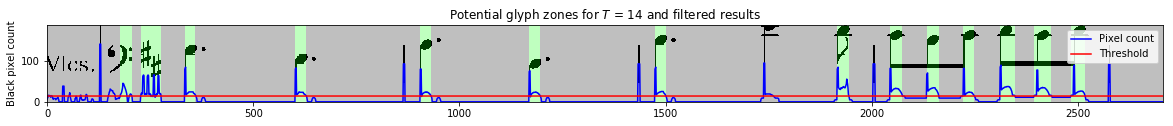

In [5]:
rgb_staff_image = np.stack((example_staff_image,) * 3, axis=-1)
zone_bboxes = score.potential_regions(example_staff_image, merge=True, thin_filter=True)
mask_image = np.zeros(rgb_staff_image.shape)
for (xmin, xmax, ymin, ymax) in zone_bboxes:
    mask_image[ymin:ymax, xmin:xmax] = GREEN
rgb_staff_image = rgb_staff_image * (1-alpha) + mask_image * alpha
rgb_staff_image = rgb_staff_image.astype('int')
plt.figure(figsize=(20,20))
plt.imshow(rgb_staff_image, extent=[0, cols, 0, rows], cmap='gray')
plt.plot(col_count, 'b-')
plt.plot([T] * cols, 'r')
plt.title('Potential glyph zones for $T$ = {} and filtered results'.format(T))
plt.ylabel('Black pixel count');
plt.legend(['Pixel count', 'Threshold']);

The next step is to move a small box of size $c$ x $c$ around all the potential zones in the image and to threshold over the amount of black pixels in that box.

The threshold, $B$, would be defined as
$B = c \cdot H \cdot 2$.

Whenever a roi would exceed that threshold, it would mean there is a potential glyph. There are going to be a lot of duplicates and false positives but training a neural network to ignore those is going to be a simple task. Here are the results.

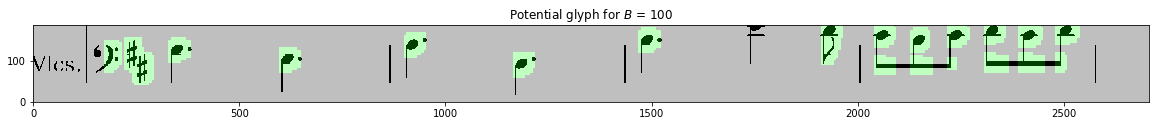

In [6]:
rgb_staff_image = np.stack((example_staff_image,) * 3, axis=-1)
mask_image = np.zeros(rgb_staff_image.shape)

B = score.kernel_threshold
for box in zone_bboxes:
    for x_min, x_max, y_min, y_max in score.convolve_box(box):
        roi = example_staff_image[y_min:y_max, x_min:x_max]
        count = np.count_nonzero(roi == 0)
        if count > B:
            mask_image[y_min:y_max, x_min:x_max] = GREEN 

rgb_staff_image = rgb_staff_image * (1-alpha) + mask_image * alpha
rgb_staff_image = rgb_staff_image.astype('int')
plt.figure(figsize=(20,20))
plt.imshow(rgb_staff_image, extent=[0, cols, 0, rows], cmap='gray')
plt.title('Potential glyph for $B$ = {}'.format(B));

## Training

The results are astonishing. Basic thresholding techniques made it possible to get a similar behavior to mask RCNN. At this point in the pipeline, we have many areas in the image that *could* contain a glyph. One could train some kind of classifier to detect classify each and every area. The downside is that there has to be a way to generate groudtruth for training to be able to discriminate between glyphs and non-glyphs. The advantage of this method is that since the areas are perfectly positioned, it is immediately possible to extract the pitch of the glyph.

To generate groundtruth for non-glyphs instances, one approach would be validate every area with groundtruth from a dataset to check if is indeed a glyph or an area that surrounds one but that is not close enough. Take for example the all the stems around a black note head. These areas do not represent a glyph. By creating a set of all the areas that hold a glyph from a dataset, the black note head in this case, every other area that does not belong to the set, including the stems, could be labeled as non-glyph.

More precisely, we will load data from the `deepscores` dataset and we will position every glyph in its respective staff. Then, we will poll every black pixel that belong to the glyphs (this is the reason we had to delete staff lines with the `staff-detect` module) after which, for every potential area (highlighted areas in the previous plot), we will pick the ones that have a decent amount of glyphs of one type.

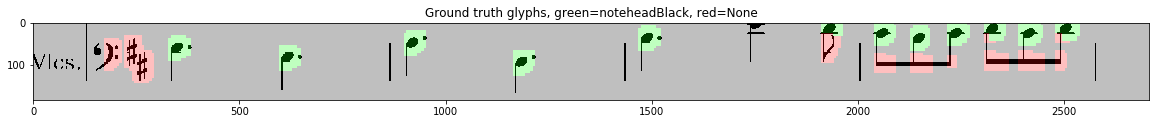

In [7]:
from score import deepscores_gt

# Location of the xml annotations of the deepscores dataset
DEEPSCORES_GT_FN = join(expanduser('~'),'Documents/data/DEEPSCORES/xml_annotations')

# The deepscores ground truth function will extract every glyph from the specified score
glyphs = deepscores_gt(test_file, DEEPSCORES_GT_FN)

# Positioning every glyph into its respective staff
score.position_glyphs(glyphs)

# We will try to extract black note heads only for this example. Everything else will be None
relevant_glyphs = ['noteheadBlack']
# Getting all training samples by implicitly using the potential glyph extraction function
X, y = score.extract_training_data(example_staff_image, example_staff, relevant_glyphs)

rgb_staff_image = np.stack((example_staff_image,) * 3, axis=-1)
mask_image = np.zeros_like(rgb_staff_image)
plt.figure(figsize=(20,20))
for x, label in zip(X, y):
    x_min, x_max, y_min, y_max = x
    if label == 'None':
        mask_image[y_min:y_max, x_min:x_max] = RED
    else:
        mask_image[y_min:y_max, x_min:x_max] = GREEN
rgb_staff_image = rgb_staff_image * (1-alpha) + mask_image * alpha
rgb_staff_image = rgb_staff_image.astype('int')
plt.imshow(rgb_staff_image)
plt.title('Ground truth glyphs, green=noteheadBlack, red=None');

Now, it is possible to generate a lot of groundtruth data for a classifier. The classifier would receive the highlighted regions of the preceding plot. If trained well, it should be able to discriminate between relevant glyphs and none glyphs. Notice how the steps so far are identical to inference and that a lof of regions of the image were filtered out with proper thresholding techniques. So far, we have tried to make it as easy as possible to the classifier. One more thing that could be done is have more relevant glyphs than necessary. This way, not every single pixel will be classified as *None* and it will be easier for the classifier to generalize. Otherwise, the *None* class will have too much of a broad type of glyphs and performance will be less than ideal.

To better illustrate our point and without any loss of generality, let us repeat the process over other scores.

## TESTS

In [8]:
n_test_files = 3
test_files = [splitext(f)[0] for f in listdir(STAV_OUTPUT_DIR) 
              if isfile(join(STAV_OUTPUT_DIR, f))][97:100]

relevant_glyphs = ['noteheadBlack', 'noteheadHalf', 'keySharp', 'accidentalNatural', 
                   'noteheadWhole','accidentalSharp']
images = [None] * 3
for i, f in enumerate(test_files):
    image = cv.imread(join(STAV_OUTPUT_DIR, f + '.png'), 0)
    rgb_image = np.stack((image,) * 3, axis=-1).astype('float')
    mask_image = np.zeros_like(rgb_image)
    
    score = Score(join(STAV_OUTPUT_DIR, f + '.xml'))
    
    for staff in score:
        staff_image = score.extract_staff_image(image, staff)
        rgb_staff_image = score.extract_staff_image(rgb_image, staff)
        staff_mask = score.extract_staff_image(mask_image, staff)
        
        glyphs = deepscores_gt(f, DEEPSCORES_GT_FN)
        score.position_glyphs(glyphs)
        
        X, y = score.extract_training_data(staff_image, staff, relevant_glyphs)
        
        for x, label in zip(X, y):
            x_min, x_max, y_min, y_max = x
            if label == 'None':
                staff_mask[y_min:y_max, x_min:x_max] = RED
            else:
                staff_mask[y_min:y_max, x_min:x_max] = GREEN
    
        
    rgb_image = rgb_image * (1 - alpha) + mask_image * alpha
    rgb_image = rgb_image.astype('int')
    images[i] = rgb_image

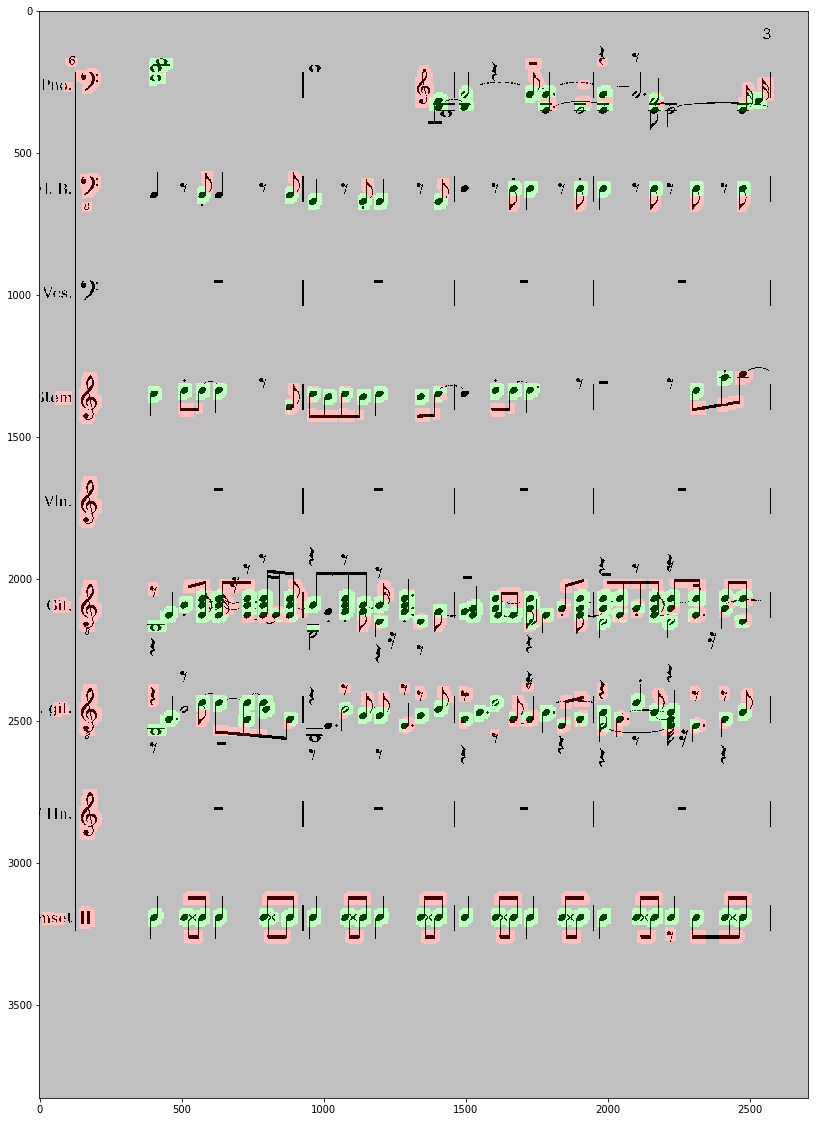

In [9]:
plt.figure(figsize=(30,20))
plt.imshow(images[0]);

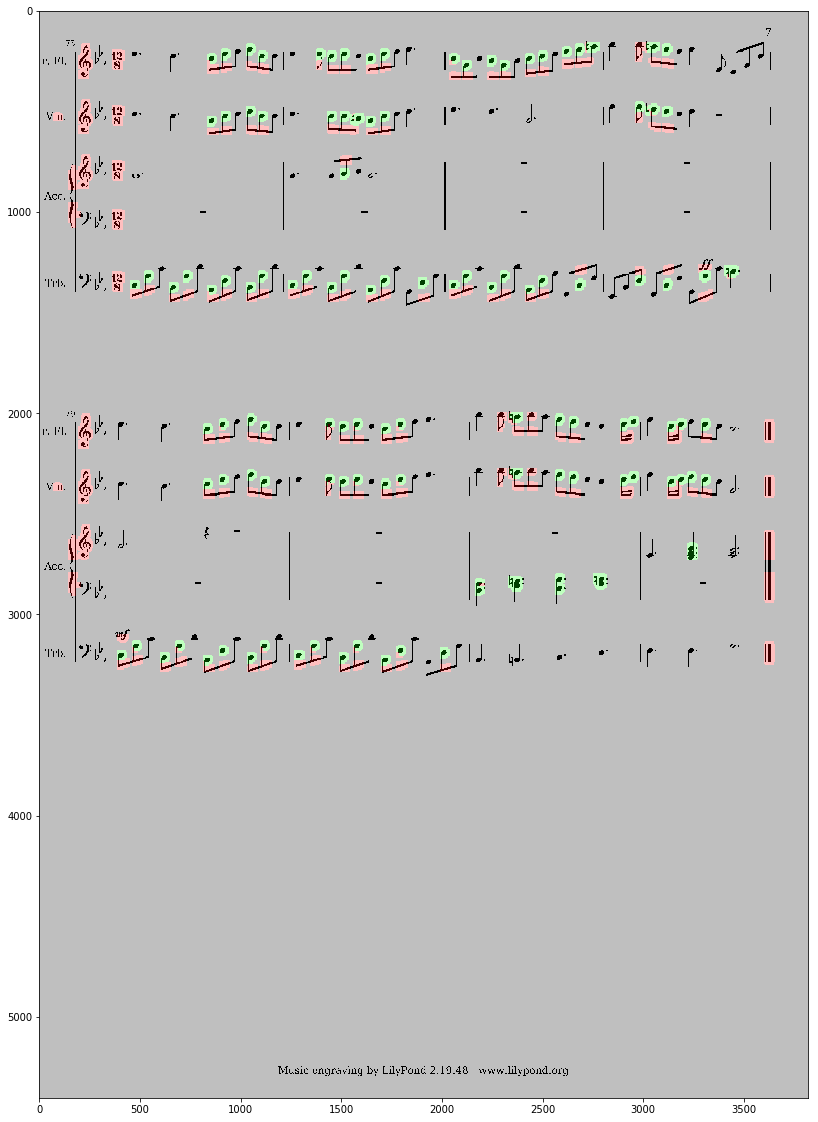

In [10]:
plt.figure(figsize=(30,20))
plt.imshow(images[1]);

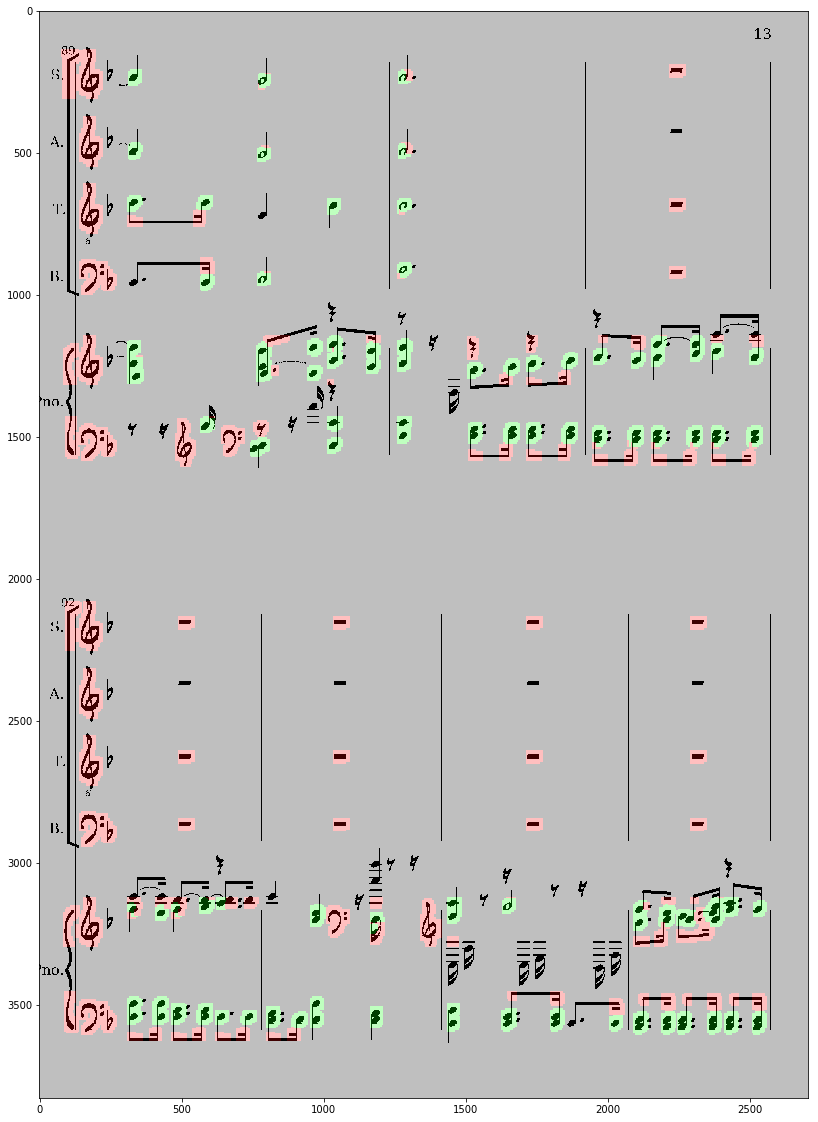

In [11]:
plt.figure(figsize=(30,20))
plt.imshow(images[2]);